# Pixel-to-pixel fiber Transmission Matrix (TM) retrieval (including Fourier correction)

Here, we aim to solve to find the true transmission matrix $A$ so that $Y = AX$ (in the complex domain), knowing only $|Y|$ and $X$ (or equivalently $|Y|^2$ and $X$).

This my open implementation of the method described in our paper: https://ieeexplore.ieee.org/document/10459341.
An example is given from a simulated Step-Index fiber dataset.

It employs Gradient Descent procedures in Pytorch & Lightning (use a NVIDIA GPU for tremendous speedups), and is done in two steps:
1. Obtain the "phase-biased" TM through GD from $|Y|$ and $X$. This gives accurate predictions in the $|Y|$ recording plane.
2. Correct the phase bias through GD from $|Z|$ and $X$, where $|Z|$ are recordings in the Fourier domain of the $|Y|$ plane. Once the phase bias is corrected, predictions are accurate in any plane.

I made it as didactic as possible, while being as open/easily adjustable as possible.
Tweak it to your own needs, but please cite the original paper!

Thanks, and happy retrieval!


## Imports & GPU support detection

In [2]:
%load_ext autoreload
%autoreload 2

import os
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch

from types import SimpleNamespace
from torch.utils.data import TensorDataset, DataLoader, random_split

from tmret.callbacks import PlotLossCallback, CleanDisplay
from tmret.losses import PearsonImageLoss
from tmret.networks import LitTransmissionMatrix, LitTMFourierCorrection
from tmret.utils import load_h5file, real_gaussian_noise, complex_to_rgb

gpu_available = torch.cuda.is_available()
print(f"GPU available: {gpu_available}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPU available: True


## Data loading and extraction (from a simulated deformable mirror into a step-index fiber)

Let's load the example dataset. This dataset has been generated from a step-index fiber model, with 144 modes at 1064 nm, and a 8x8 actuators deformable mirror (illuminated by a collimated Gaussian beam).

In [6]:
path = r"../resources"
file = r"synth_dset_step_lambda=1064nm_Nmodes=269_degen=True_len=5000_mirr=64_exp_noise.hdf5"

data = SimpleNamespace(
    load_h5file(
        os.path.join(path, file),
    )
)

Let's plot some info about the dataset's contents:

In [7]:
# Checking what are the available attributes
print("Available attributes:\n", list(vars(data).keys()), "\n")

print("- Optical wavelength used for the simulation:",data.wavelength)
print("- Number of (degenerated) LP modes used for the simulation:", data.N_modes)
print("- Near field intensity tensor shape:", data.intens.shape)
print("- Far field intensity tensor shape:", data.intens_transf.shape)
print("- DM macropixels tensor shape:", data.macropixels_energy.shape)
print("- DM phase maps tensor shape:", data.phase_maps.shape)
print("- Transmission 'matrix' (convenient) tensor shape:", data.transfer_matrix.shape)
print("- Transmission matrix tensor shape:", data.reshaped_transfer_matrix.shape)

Available attributes:
 ['N_modes', 'coupling_matrix', 'degenerated_modes', 'intens', 'intens_transf', 'length', 'macropixels_energy', 'phase_maps', 'reshaped_transfer_matrix', 'slice_length', 'transfer_matrix', 'wavelength'] 

- Optical wavelength used for the simulation: 1.064e-06
- Number of (degenerated) LP modes used for the simulation: 269
- Near field intensity tensor shape: (64, 64, 3000)
- Far field intensity tensor shape: (64, 64, 3000)
- DM macropixels tensor shape: (8, 8)
- DM phase maps tensor shape: (8, 8, 3000)
- Transmission 'matrix' (convenient) tensor shape: (60, 64, 64)
- Transmission matrix tensor shape: (4096, 60)


Let's have a quick look at one example:

Text(0.5, 1.0, 'Far field intensity')

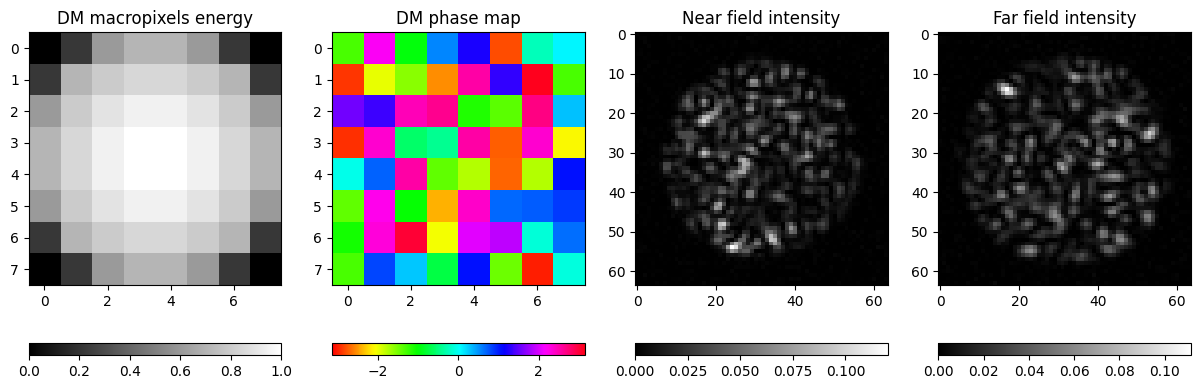

In [8]:
length = data.intens.shape[-1]
idx = np.random.randint(length)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(data.macropixels_energy, vmin=0, cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("DM macropixels energy")

plt.subplot(1, 4, 2)
plt.imshow(data.phase_maps[..., idx], vmin=-np.pi, vmax=+np.pi, cmap="hsv")
plt.colorbar(orientation='horizontal')
plt.title("DM phase map")

plt.subplot(1, 4, 3)
plt.imshow(data.intens[..., idx], vmin=0, cmap="grey")
plt.colorbar(orientation='horizontal')
plt.title("Near field intensity")

plt.subplot(1, 4, 4)
plt.imshow(data.intens_transf[..., idx], vmin=0, cmap="grey")
plt.colorbar(orientation='horizontal')
plt.title("Far field intensity")

## Dataset preparation for TM learning

Let's prepare that data for our ML procedures, we basically want the item index as the first dimension.

In [10]:
def add_intensity_noise(intensity_tensor, sigma: float = 0):
    intensity_tensor += real_gaussian_noise(
        intensity_tensor, sigma=sigma * intensity_tensor.max()
    )
    return np.abs(intensity_tensor)

# Input fields (add macropixels amplitude to phase maps, and delete very low macropixels relative energies -> corners here)
X = np.sqrt(np.expand_dims(data.macropixels_energy, -1)) * np.exp(1j * data.phase_maps)
X = X.reshape(-1, length)
X = np.delete(X, [0, 7, 55, 63], axis=0)
X = np.moveaxis(X, 0, -1)
print(X.shape)

noise_level = 0.001

# Near field amplitudes
Y = np.sqrt(add_intensity_noise(data.intens, noise_level))
Y = Y.reshape(-1, length)
Y = np.moveaxis(Y, 0, -1)
print(Y.shape)

# Far field amplitudes
Z = np.sqrt(add_intensity_noise(data.intens_transf, noise_level))
Z = np.moveaxis(Z, -1, 0)
print(Z.shape)

(3000, 60)
(3000, 4096)
(3000, 64, 64)


Make Lightning compatible Dataloaders from the preprocessed data

In [11]:
batch_size = 32
split_ratio = 0.8

input_tensor = torch.from_numpy(X).to(torch.cdouble)
print(input_tensor.shape)

output_tensor = torch.from_numpy(Y).to(torch.double)
print(output_tensor.shape)

# Create the full dataset, split, and create the loaders
dataset = TensorDataset(input_tensor, output_tensor)
train_size = int(split_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

torch.Size([3000, 60])
torch.Size([3000, 4096])


## Retrieving the "phase-biased" tranmission matrix

### Model preparation and training

Let's define the model to train

In [13]:
model = LitTransmissionMatrix(
    input_size = input_tensor.shape[1],
    output_size = output_tensor.shape[1],
    train_loss_fn = torch.nn.MSELoss(),
    optimizer=torch.optim.Adam,
    optimizer_kwargs=dict(
        lr=1e-3,
        weight_decay=0*1e-5,
    ),
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_kwargs=dict(
        factor=0.5,
        patience=5,
        threshold=0.05,
        threshold_mode='rel',
        cooldown=2,
        min_lr=1e-7,
    ),
)

Now let's train it

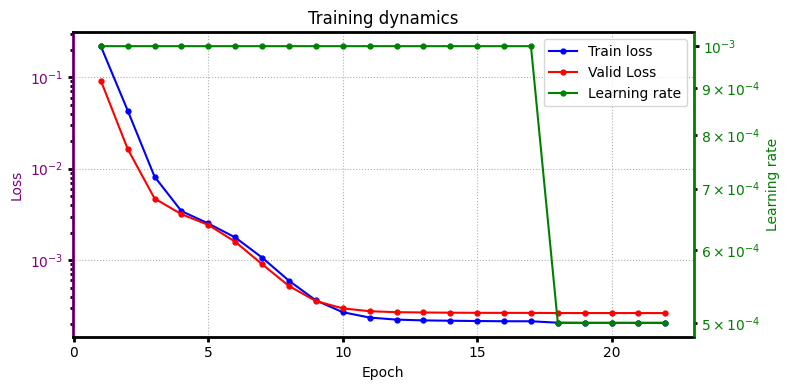


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

C:\Users\saucourt\dev\venvs\test_tmret\Lib\site-packages\IPython\core\interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [14]:
trainer = L.Trainer(
    accelerator="gpu" if gpu_available else "cpu",
    devices=1 if gpu_available else None,
    max_epochs=50,
    enable_progress_bar=True,
    callbacks=[
        CleanDisplay(),
        PlotLossCallback(),
    ],
)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

If you want to retrieve the training values!

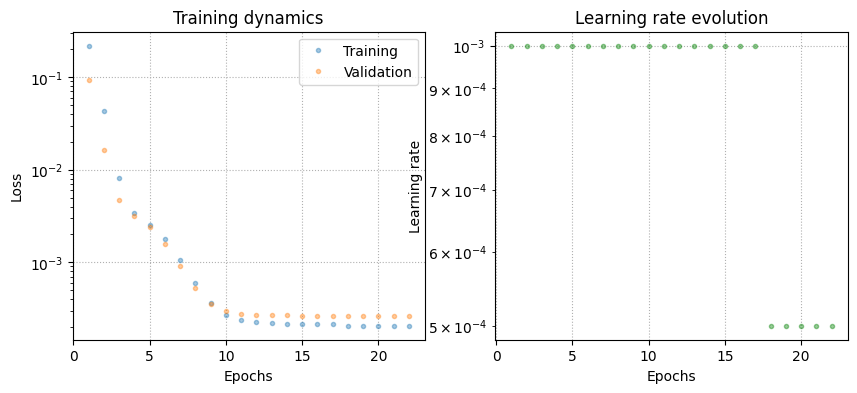

In [15]:
plot_callback = trainer.callbacks[-4]

training_metrics = dict(
    epochs = np.array(plot_callback.epochs),
    train_loss = np.array(plot_callback.train_losses),
    val_loss = np.array(plot_callback.val_losses),
    lr = np.array(plot_callback.lr),
)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(training_metrics["epochs"], training_metrics["train_loss"], ls='none', marker='.', label="Training", alpha=0.4)
plt.plot(training_metrics["epochs"], training_metrics["val_loss"], ls='none', marker='.', label="Validation", alpha=0.4)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training dynamics')
plt.grid(ls=':')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_metrics["epochs"], training_metrics["lr"], ls='none', marker='.', color='g', alpha=0.4)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.title('Learning rate evolution')
plt.grid(ls=':')

### Model evaluation

In [16]:
def eval_model(model, val_loader):
    model.eval()

    preds = []
    trues = []

    for i, batch in enumerate(val_loader):
        X, Y = batch
        Z = model(X.to(model.device))

        if i == 0:
            preds = Z.cpu().detach().numpy()
            trues = Y.cpu().detach().numpy()
        else:
            preds = np.concatenate([preds, Z.cpu().detach().numpy()], axis=0)
            trues = np.concatenate([trues, Y.cpu().detach().numpy()], axis=0)
    return preds, trues

preds, trues = eval_model(model, val_loader)

print(preds.shape)
print(trues.shape)

(600, 4096)
(600, 4096)


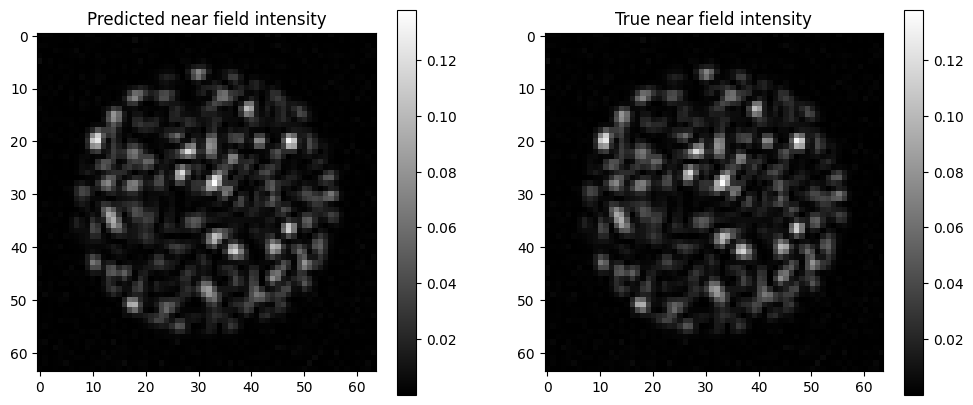

In [17]:
idx = np.random.randint(preds.shape[0])

y_pred = preds[idx].reshape(64, 64)
y_true = preds[idx].reshape(64, 64)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_pred ** 2, cmap='gray')
plt.title('Predicted near field intensity')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y_true ** 2, cmap='gray')
plt.title('True near field intensity')
plt.colorbar()

### Checking the retrieved "phase-biased" transmission matrix

Let's check the amplitudes first, they should be pretty identical

(60, 64, 64)
(4096, 60)
(4096, 60)
(60, 64, 64)


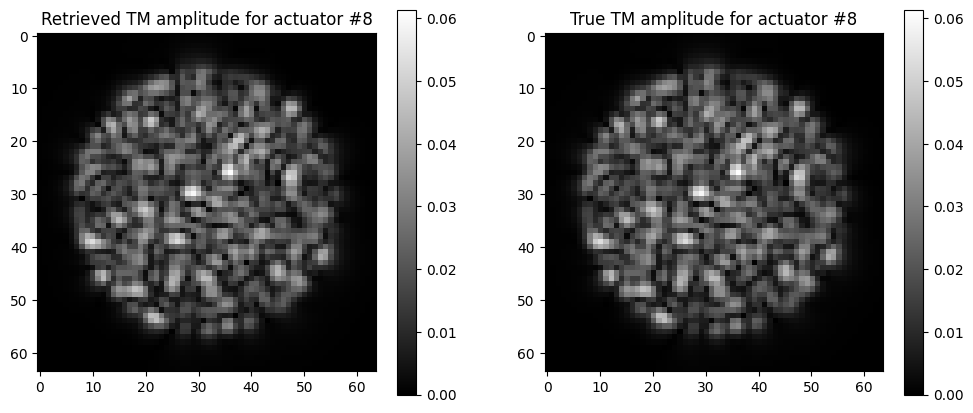

In [18]:
print(data.transfer_matrix.shape)
print(data.reshaped_transfer_matrix.shape)

# Weights extraction from the trained model
weights = model.model[0].weight.detach().cpu().numpy()
print(weights.shape)

# Reshaping for easier comparison (image-sized output channels)
reshaped_weights = np.moveaxis(weights, 0, -1).reshape(data.transfer_matrix.shape)
print(reshaped_weights.shape)

act_idx = 8

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.abs(np.squeeze(data.transfer_matrix[act_idx, ...])), vmin=0, cmap='gray')
plt.title(f"Retrieved TM amplitude for actuator #{act_idx}")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.abs(np.squeeze(data.transfer_matrix[act_idx, ...])), vmin=0, cmap='gray')
plt.title(f"True TM amplitude for actuator #{act_idx}")
plt.colorbar()

Phase are difficult to compare directly as there is a phase-bias that we will correct next, and it is random.

But if we normalize to one column, which means we are taking the phase of the output speckle as a reference wavefront, the "phase-biased" retrieved TM should be very similar.

Text(0.5, 1.0, 'True TM field for actuator #8')

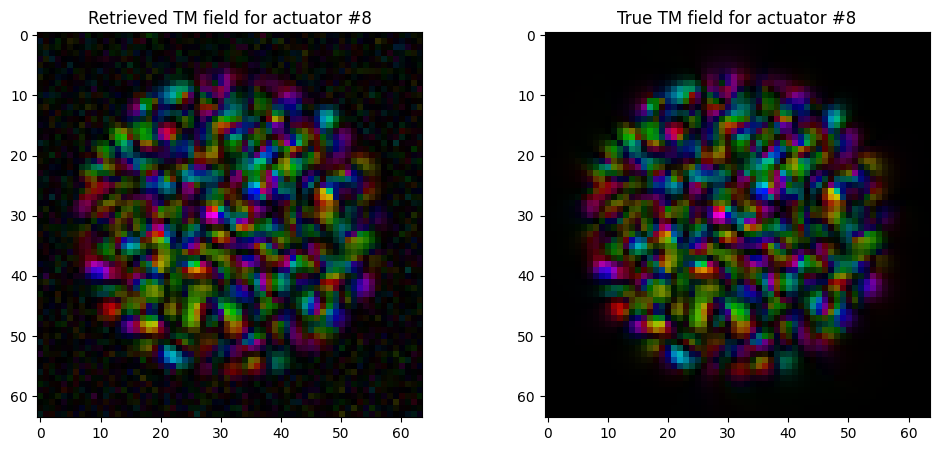

In [19]:
tm_r = data.transfer_matrix * np.exp(-1j * np.angle(data.transfer_matrix[0, ...]))
tmh_r = reshaped_weights * np.exp(-1j * np.angle(reshaped_weights[0, ...]))

act_idx = 8

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(complex_to_rgb(np.squeeze(tmh_r[act_idx, ...])))
plt.title(f"Retrieved TM field for actuator #{act_idx}")

plt.subplot(1, 2, 2)
plt.imshow(complex_to_rgb(np.squeeze(tm_r[act_idx, ...])))
plt.title(f"True TM field for actuator #{act_idx}")

## Phase-bias correction from a small set of Fourier recordings

We need to prepare some of the Fourier data, here called Z (it won't be padded directly, the padding value will be passed to the Lightning model instead).

Those Fourier transforms have been computed in the simulation by padding the initial 64x64 near fields to 128x128. We need to use the same size here to ensure convergence by matching the discrete k-spaces grids.

Please note that, in experimental conditions, the padded window size formula is as follows:
$$ N_{window} = \frac{\lambda f}{s_{NF} \cdot s_{FF}} $$

Where:
- $N_{window}$ is the size of the images on both planes
- $\lambda$ is the optical wavelength (assumes a quasi-monochromatic illumination)
- $f$ is the focal length used between to obtain the near field from the far field
- $s_{NF}$ is the size of one pixel in the near field
- $s_{FF}$ is the size of one pixel in the far field

If the data is further processed (pooled for instance to reduce the dimensions), the pixel sizes has to be adjusted accordingly!

Here we are going to use only a few tens of Fourier recordings to find the phase bias, and prepare a Lightning compatible DataLoader:

In [20]:
n_fourier = 20
idx_fourier = np.unique(np.random.randint(low=0, high=(Z.shape[0]-1), size=n_fourier))

input_fourier_tensor = torch.from_numpy(X[idx_fourier, ...]).to(torch.cdouble)
print(input_fourier_tensor.shape)

output_fourier_tensor = torch.from_numpy(Z[idx_fourier, ...]).to(torch.double)
print(output_fourier_tensor.shape)

corr_dataset = TensorDataset(input_fourier_tensor, output_fourier_tensor)
corr_loader = DataLoader(corr_dataset, batch_size=len(dataset), shuffle=False)  # Single batch

torch.Size([20, 60])
torch.Size([20, 64, 64])


Now let's define the correction model, which reuses the previous Transmission Matrix model (only a phase bias will be optimized):

In [21]:
loss_fn = PearsonImageLoss(invert=True, power=1)

corr_model = LitTMFourierCorrection(
    tm_model = model,
    pad_to = 128,
    train_loss_fn = loss_fn,
    optimizer=torch.optim.Adam,
    optimizer_kwargs=dict(
        lr=5e-1,
        weight_decay=0*1e-5,
    ),
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_kwargs=dict(
        factor=0.5,
        patience=20,
        threshold=0.05,
        threshold_mode='rel',
        cooldown=2,
        min_lr=1e-7,
    ),
)

C:\Users\saucourt\dev\venvs\test_tmret\Lib\site-packages\lightning\pytorch\utilities\parsing.py:213: Attribute 'tm_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['tm_model'])`.


Let's train the phase bias correction model:

In [22]:
# Train
corr_trainer = L.Trainer(
    accelerator="gpu" if gpu_available else "cpu",
    devices=1 if gpu_available else None,
    max_epochs=150,
    enable_progress_bar=True,
    callbacks=[
        CleanDisplay(),
        PlotLossCallback(skip_validation=True),
    ],
)
corr_trainer.fit(corr_model, train_dataloaders=corr_loader)


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

If you want to retrieve the training values!

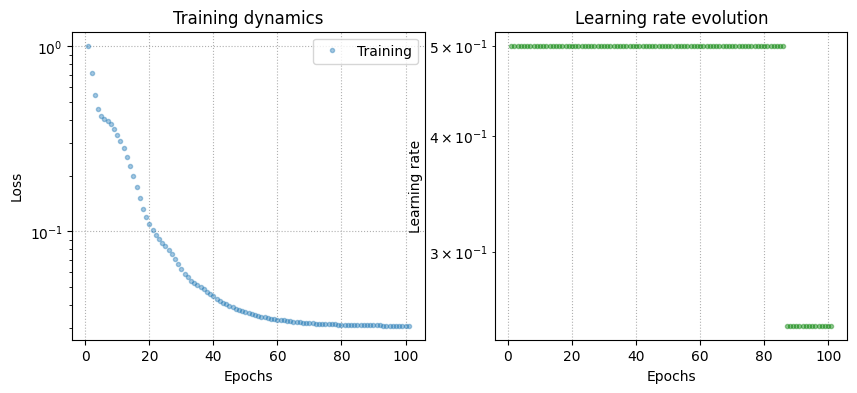

In [23]:
corr_plot_callback = corr_trainer.callbacks[-4]

corr_training_metrics = dict(
    epochs = np.array(corr_plot_callback.epochs),
    train_loss = np.array(corr_plot_callback.train_losses),
    val_loss = np.array(corr_plot_callback.val_losses),
    lr = np.array(corr_plot_callback.lr),
)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(corr_training_metrics["epochs"], corr_training_metrics["train_loss"], ls='none', marker='.', label="Training", alpha=0.4)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training dynamics')
plt.grid(ls=':')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(corr_training_metrics["epochs"], corr_training_metrics["lr"], ls='none', marker='.', color='g', alpha=0.4)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.title('Learning rate evolution')
plt.grid(ls=':')

### Checking the "phase-biased" corrected TM

(60, 64, 64)
(4096, 60)
(60, 64, 64)


Text(0.5, 1.0, 'Retrieved TM field for actuator #30')

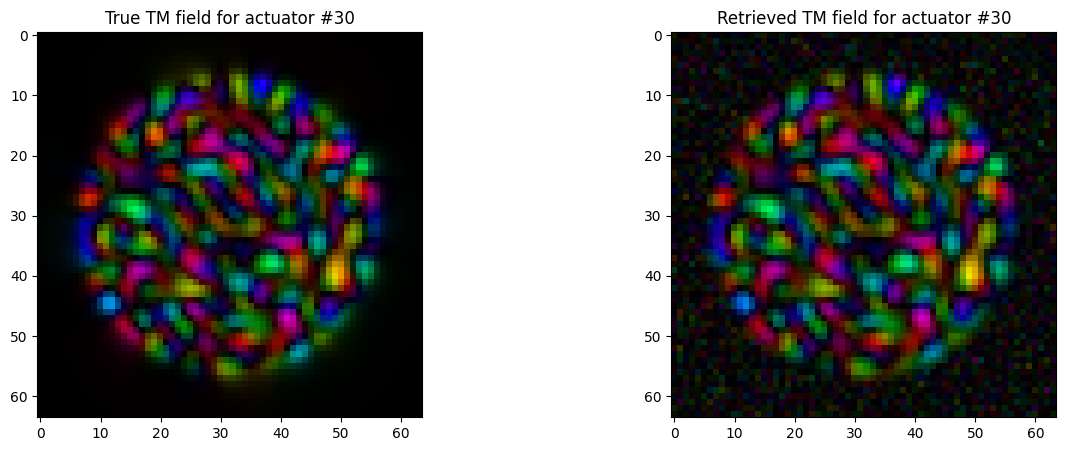

In [28]:
print(data.transfer_matrix.shape)
print(data.reshaped_transfer_matrix.shape)

weights = corr_model.tm_model.model[0].weight.detach().cpu().numpy()
phase_bias = np.moveaxis(corr_model.phase_bias.detach().cpu().numpy(), -1, 0)
weights =  weights * np.exp(1j * phase_bias) # Correct from the trained phase biase
reshaped_weights = np.moveaxis(weights, 0, -1).reshape(data.transfer_matrix.shape)
print(reshaped_weights.shape)

# Let's normalize to a common single pixel for phase comparison
tmc = data.transfer_matrix * np.exp(-1j * np.angle(data.transfer_matrix[0, 32, 32]))
tmch = reshaped_weights * np.exp(-1j * np.angle(reshaped_weights[0, 32, 32]))

act_idx = 30
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(complex_to_rgb(np.squeeze(tmc[act_idx, ...])))
plt.title(f"True TM field for actuator #{act_idx}")

plt.subplot(1, 2, 2)
plt.imshow(complex_to_rgb(np.squeeze(tmch[act_idx, ...])))
plt.title(f"Retrieved TM field for actuator #{act_idx}")

And let's show the optimized phase bias!

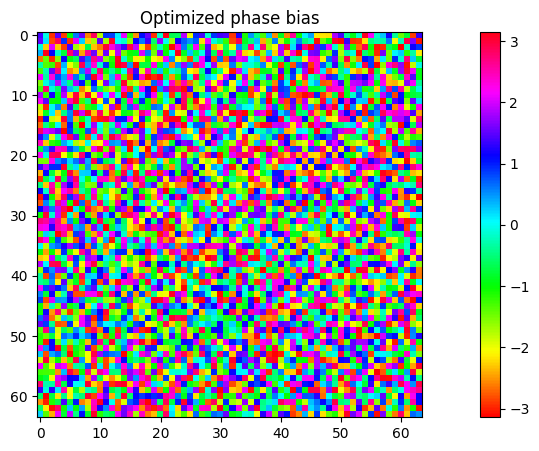

In [29]:
plt.figure(figsize=(15, 5))
plt.imshow(np.angle(np.exp(1j * phase_bias.reshape(64, 64))), vmin=-np.pi, vmax=+np.pi, cmap='hsv')
plt.title(f"Optimized phase bias")
plt.colorbar()